In [1]:
# 1. Install libraries
!pip install transformers datasets scikit-learn matplotlib seaborn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 4.5 MB/s eta 0:00:00a 0:00:01
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.12.0 which is incompatible.
torch 2.5.1+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.8.4.1 which is incompatible.
torch 2.5.1+cu124 requires nvidia-cudnn-cu12==9.1.0.70; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cudnn-cu12 9.3.0.75 which is incompatible.
torch 2.5.1+cu124 requires nvidia-cufft-cu12==11.2.1.3; platform_system == "Linux" and platform_machine == "x86_64",

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Epoch 1: 100%|██████████| 1266/1266 [07:39<00:00,  2.75it/s, loss=0.38] 



 Epoch 1 finished:
Train Loss: 0.5460
Val Loss: 0.5263
Val Accuracy: 0.6919


Epoch 2: 100%|██████████| 1266/1266 [07:42<00:00,  2.74it/s, loss=0.496]



 Epoch 2 finished:
Train Loss: 0.4619
Val Loss: 0.5307
Val Accuracy: 0.7229


Epoch 3: 100%|██████████| 1266/1266 [07:43<00:00,  2.73it/s, loss=0.553] 



 Epoch 3 finished:
Train Loss: 0.3509
Val Loss: 0.6048
Val Accuracy: 0.7110


Epoch 4: 100%|██████████| 1266/1266 [07:42<00:00,  2.74it/s, loss=0.173] 



 Epoch 4 finished:
Train Loss: 0.2573
Val Loss: 0.7046
Val Accuracy: 0.7087


Epoch 5: 100%|██████████| 1266/1266 [07:42<00:00,  2.74it/s, loss=0.089] 



 Epoch 5 finished:
Train Loss: 0.1933
Val Loss: 0.9073
Val Accuracy: 0.7061

 Model and tokenizer saved at ./saved_bert_model

 Classification Report:
              precision    recall  f1-score   support

           0     0.5524    0.5604    0.5564      1665
           1     0.7830    0.7775    0.7803      3398

    accuracy                         0.7061      5063
   macro avg     0.6677    0.6689    0.6683      5063
weighted avg     0.7072    0.7061    0.7066      5063



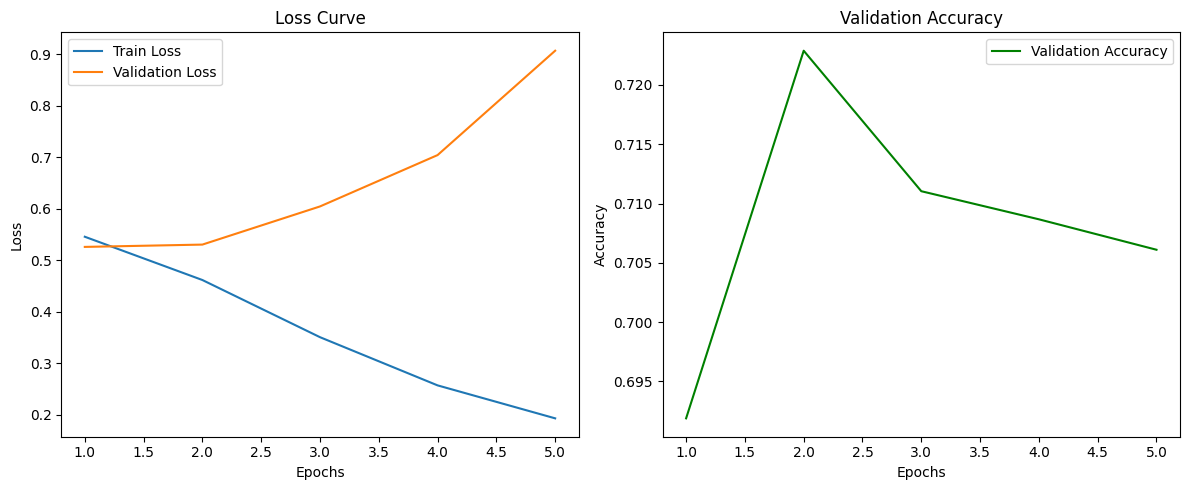

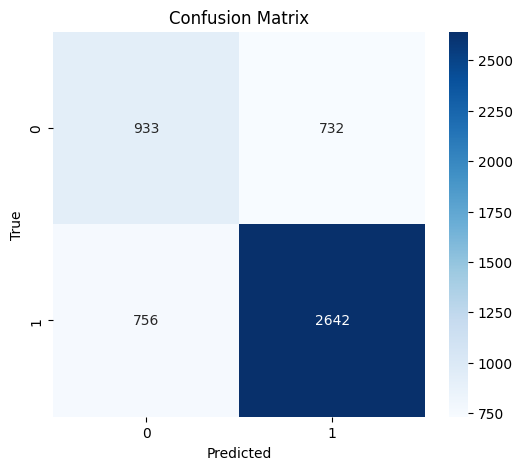

In [3]:


import pandas as pd
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW
from transformers import BertTokenizer, BertForSequenceClassification
from tqdm import tqdm
import os

# 2. Load your dataset
df = pd.read_csv('/kaggle/input/multilingual-meme-datasets/final_datasets.csv')  # Replace with your path
df = df[['translated_text', 'label']].dropna()

# 3. Prepare Train and Validation sets
train_texts, val_texts, train_labels, val_labels = train_test_split(
    df['translated_text'].tolist(), 
    df['label'].tolist(), 
    test_size=0.2,
    random_state=42
)

# 4. Tokenization
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

train_encodings = tokenizer(train_texts, truncation=True, padding=True, max_length=128)
val_encodings = tokenizer(val_texts, truncation=True, padding=True, max_length=128)

# 5. Create Dataset class
class MemeDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels
    
    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item
    
    def __len__(self):
        return len(self.labels)

train_dataset = MemeDataset(train_encodings, train_labels)
val_dataset = MemeDataset(val_encodings, val_labels)

# 6. Load model
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)

# 7. Set up optimizer
optimizer = AdamW(model.parameters(), lr=5e-5)

# 8. DataLoaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

# 9. Training Loop with Loss Tracking
epochs = 5
train_losses = []
val_losses = []
val_accuracies = []

for epoch in range(epochs):
    model.train()
    total_train_loss = 0
    loop = tqdm(train_loader, leave=True)

    for batch in loop:
        optimizer.zero_grad()
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        loss = outputs.loss
        total_train_loss += loss.item()
        loss.backward()
        optimizer.step()

        loop.set_description(f'Epoch {epoch+1}')
        loop.set_postfix(loss=loss.item())

    avg_train_loss = total_train_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    #  Validation Phase
    model.eval()
    total_val_loss = 0
    preds, true_labels = [], []

    with torch.no_grad():
        for batch in val_loader:
            batch = {k: v.to(device) for k, v in batch.items()}
            outputs = model(**batch)
            loss = outputs.loss
            total_val_loss += loss.item()

            logits = outputs.logits
            preds.extend(torch.argmax(logits, axis=1).cpu().numpy())
            true_labels.extend(batch['labels'].cpu().numpy())




    avg_val_loss = total_val_loss / len(val_loader)
    val_losses.append(avg_val_loss)

    acc = accuracy_score(true_labels, preds)
    val_accuracies.append(acc)

    print(f"\n Epoch {epoch+1} finished:")
    print(f"Train Loss: {avg_train_loss:.4f}")
    print(f"Val Loss: {avg_val_loss:.4f}")
    print(f"Val Accuracy: {acc:.4f}")

# 10. Save model and tokenizer
save_path = './saved_bert_model'
os.makedirs(save_path, exist_ok=True)

model.save_pretrained(save_path)
tokenizer.save_pretrained(save_path)

print("\n Model and tokenizer saved at", save_path)

# 11.  Confusion Matrix and Classification Report
cm = confusion_matrix(true_labels, preds)
report = classification_report(true_labels, preds, digits=4)

print("\n Classification Report:")
print(report)

# 12.  Plot Loss and Accuracy Graphs
epochs_range = range(1, epochs+1)

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(epochs_range, train_losses, label='Train Loss')
plt.plot(epochs_range, val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Curve')
plt.legend()

plt.subplot(1,2,2)
plt.plot(epochs_range, val_accuracies, label='Validation Accuracy', color='green')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

# 13.  Confusion matrix plot
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()
